In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kurtosis, zscore, skew

## Vamos a trabajar en los outliers de la columna best, que es la que pretendemos clasificar en el modelo

In [36]:
df = pd.read_csv('data/GEDEvent_v25_1.csv', low_memory=False)

print("Descriptive statistics for 'best':")
print(df['best'].describe())

Descriptive statistics for 'best':
count    385918.000000
mean         10.253844
std         347.680699
min           0.000000
25%           1.000000
50%           2.000000
75%           4.000000
max      121848.000000
Name: best, dtype: float64


## Limpieza de las columnas best, high y low & Feature Engineering de la nueva columna best_est_cleaned

In [38]:
# -------------------------------------------------------------------
# 1) Asegurar tipos numéricos
#    - Por si hay strings o valores no numéricos, los forzamos a NaN
#    - Esto evita errores en cálculos posteriores
# -------------------------------------------------------------------
for col in ["low", "best", "high"]:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# -------------------------------------------------------------------
# 2) Estandarizar inconsistencias entre low y high
#    - A veces high < low por error de carga. Si pasa, los intercambiamos.
# -------------------------------------------------------------------
low  = df["low"]
high = df["high"]

swap_mask = low.notna() & high.notna() & (high < low)
low_fixed  = np.where(swap_mask, high, low)
high_fixed = np.where(swap_mask, low,  high)

df["low_std"]  = low_fixed
df["high_std"] = high_fixed

# -------------------------------------------------------------------
# 3) Construir una estimación central unificada: best_est_cleaned
#    - Usamos 'best' si está disponible.
#    - Si no hay 'best' pero sí 'low' y 'high', usamos el promedio (balanceado).
#    - Si sólo hay 'high', usamos 'high'; si sólo hay 'low', usamos 'low'.
#    - Si existen ambos límites, además 'clampeamos' a [low, high] para asegurar
#      la relación lógica low ≤ best_est_cleaned ≤ high.
# -------------------------------------------------------------------
best = df["best"].copy()
low  = df["low_std"]
high = df["high_std"]

# Caso: falta BEST y existen LOW y HIGH -> promedio
mask_both = best.isna() & low.notna() & high.notna()
best_clean = best.where(~mask_both, (low + high) / 2)

# Caso: falta BEST y sólo existe HIGH -> usar HIGH
mask_only_high = best_clean.isna() & high.notna() & low.isna()
best_clean = best_clean.where(~mask_only_high, high)

# Caso: falta BEST y sólo existe LOW -> usar LOW
mask_only_low = best_clean.isna() & low.notna() & high.isna()
best_clean = best_clean.where(~mask_only_low, low)

# Clampeo a [LOW, HIGH] si ambos existen
bounds_mask = low.notna() & high.notna()
best_clean = np.where(bounds_mask, np.clip(best_clean, low, high), best_clean)

# -------------------------------------------------------------------
# 4) Regla adicional: si best_est_cleaned == 0 pero LOW>0 o HIGH>0,
#    reemplazar por max(LOW, HIGH).
#    - Evita subestimar eventos con letalidad positiva codificados como 0.
# -------------------------------------------------------------------
zero_mask = (best_clean == 0) & (
    ((low.notna()) & (low > 0)) |
    ((high.notna()) & (high > 0))
)
best_clean = np.where(zero_mask, np.nanmax(np.vstack([low, high]), axis=0), best_clean)

# Guardamos versión final unificada
df["best_est_cleaned"] = pd.to_numeric(best_clean, errors="coerce")

# Chequeo de coherencia: low ≤ best_est_cleaned ≤ high (cuando hay ambos)
violations = df[bounds_mask & ((df["best_est_cleaned"] < df["low_std"]) | (df["best_est_cleaned"] > df["high_std"]))]
print(f"Violaciones restantes de low ≤ best_est_cleaned ≤ high: {len(violations)}")

print("\nFilas donde 0 fue corregido a no-cero (muestra):")
print(df.loc[zero_mask, ["low_std", "best", "high_std", "best_est_cleaned"]].head())

# ===========================================
# Análisis de outliers en 'best_est_cleaned'
# ===========================================

x = df["best_est_cleaned"].dropna()

# -------------------------------------------------------------------
# 5) IQR clásico (lineal) — Nota: puede ser poco representativo
#    en distribuciones muy sesgadas con cola pesada.
# -------------------------------------------------------------------
Q1_lin = x.quantile(0.25)
Q3_lin = x.quantile(0.75)
IQR_lin = Q3_lin - Q1_lin
low_bound_lin  = Q1_lin - 1.5 * IQR_lin
high_bound_lin = Q3_lin + 1.5 * IQR_lin

print("\n[IQR lineal] Q1, Q3, IQR, límites:")
print(f"Q1={Q1_lin:.2f}, Q3={Q3_lin:.2f}, IQR={IQR_lin:.2f}, lower={low_bound_lin:.2f}, upper={high_bound_lin:.2f}")

# -------------------------------------------------------------------
# 6) IQR en log-escala — Recomendado para colas pesadas
#    - Aplicamos log1p para manejar ceros: log(1 + x)
#    - Calculamos IQR en log-escala y regresamos a la escala original con expm1
# -------------------------------------------------------------------
logx = np.log1p(x)
Q1_log = np.percentile(logx, 25)
Q3_log = np.percentile(logx, 75)
IQR_log = Q3_log - Q1_log

low_bound_log  = np.expm1(Q1_log - 1.5 * IQR_log)
high_bound_log = np.expm1(Q3_log + 1.5 * IQR_log)

print("\n[IQR log-escala] Q1, Q3, IQR, límites (reconvertidos a escala original):")
print(f"Q1_log={Q1_log:.3f}, Q3_log={Q3_log:.3f}, IQR_log={IQR_log:.3f}")
print(f"lower≈{low_bound_log:.2f}, upper≈{high_bound_log:.2f}")

# -------------------------------------------------------------------
# 7) Alternativa basada en percentiles (robusta y simple)
#    - Tratamos, por ejemplo, el 1% superior como outliers
# -------------------------------------------------------------------
p01 = x.quantile(0.01)
p99 = x.quantile(0.99)
print("\n[Percentiles] 1% y 99% como límites:")
print(f"p01={p01:.2f}, p99={p99:.2f}")

# -------------------------------------------------------------------
# 8) Z-score en log-escala (3 desviaciones como umbral típico)
#    - Estandariza en log-espacio para no estar dominado por outliers
# -------------------------------------------------------------------
z = zscore(logx)
z_mask = np.abs(z) > 3
n_z_outliers = z_mask.sum()
print(f"\n[Z-score log] Outliers con |z|>3: {n_z_outliers}")

# -------------------------------------------------------------------
# 9) Elegimos un criterio para construir df_no_outliers
#    - Recomendado: IQR en log-escala (más representativo para colas pesadas)
# -------------------------------------------------------------------
df_no_outliers = df[df["best_est_cleaned"].between(low_bound_log, high_bound_log, inclusive="both")]

print(f"\nEventos totales: {len(df)}, sin outliers (IQR log): {len(df_no_outliers)}")

# -------------------------------------------------------------------
# 10) Kurtosis antes vs después (mide cola pesada; menor tras recorte)
# -------------------------------------------------------------------
k_before = kurtosis(x, fisher=True, nan_policy="omit")
k_after  = kurtosis(df_no_outliers["best_est_cleaned"].dropna(), fisher=True, nan_policy="omit")
print(f"\nKurtosis antes:  {k_before:.2f}")
print(f"Kurtosis después: {k_after:.2f}")

Violaciones restantes de low ≤ best_est_cleaned ≤ high: 0

Filas donde 0 fue corregido a no-cero (muestra):
     low_std  best  high_std  best_est_cleaned
49         0     0       200               200
98         0     0       400               400
107        0     0       600               600
114        0     0         3                 3
149        0     0       400               400

[IQR lineal] Q1, Q3, IQR, límites:
Q1=1.00, Q3=5.00, IQR=4.00, lower=-5.00, upper=11.00

[IQR log-escala] Q1, Q3, IQR, límites (reconvertidos a escala original):
Q1_log=0.693, Q3_log=1.792, IQR_log=1.099
lower≈-0.62, upper≈30.18

[Percentiles] 1% y 99% como límites:
p01=1.00, p99=97.00

[Z-score log] Outliers con |z|>3: 6510

Eventos totales: 385918, sin outliers (IQR log): 371994

Kurtosis antes:  53042.91
Kurtosis después: 8.42


## Outliers de Best

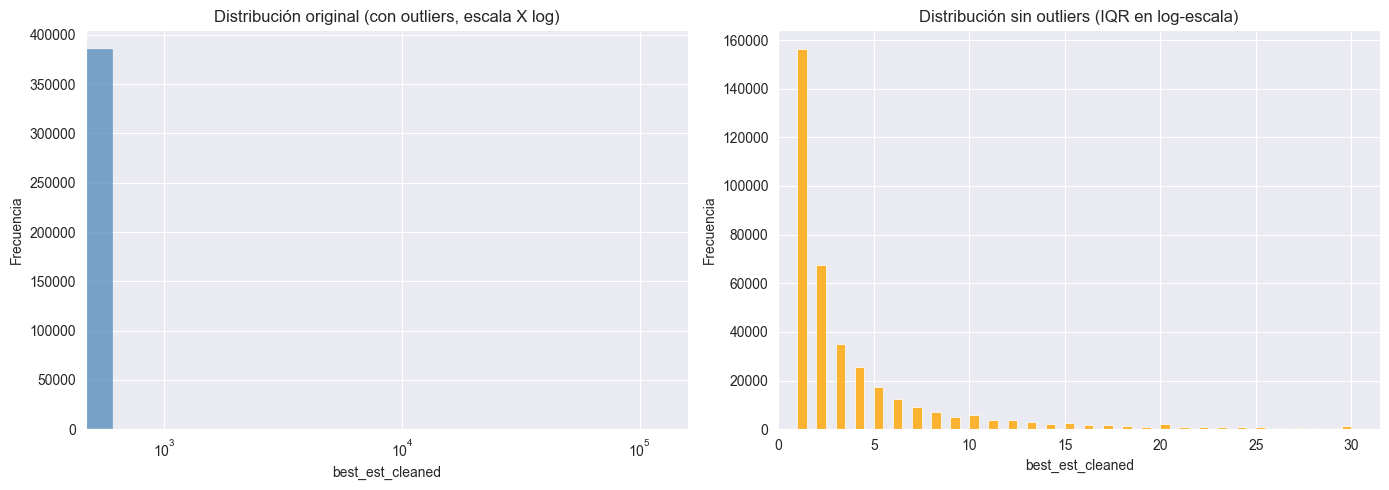

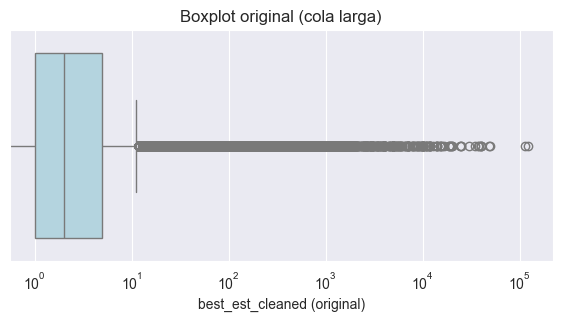

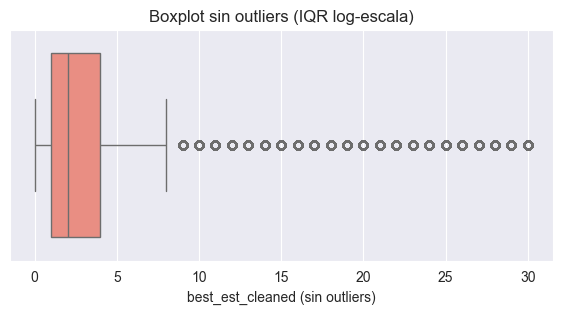

In [40]:
# -------------------------------------------------------------------
# 11) Visualizaciones separadas para no “aplastar” la escala
#     - Izquierda: distribución original (x en log)
#     - Derecha: sin outliers (escala lineal)
# -------------------------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original con cola larga: usar escala log en X
sns.histplot(x, bins=200, color='steelblue', alpha=0.7, ax=axes[0])
axes[0].set_title("Distribución original (con outliers, escala X log)")
axes[0].set_xlabel("best_est_cleaned")
axes[0].set_ylabel("Frecuencia")
axes[0].set_xscale('log')

# Sin outliers (IQR log): escala lineal y foco en rango útil
sns.histplot(df_no_outliers["best_est_cleaned"], bins=60, color='orange', alpha=0.8, ax=axes[1])
axes[1].set_xlim(0, df_no_outliers["best_est_cleaned"].max() * 1.05)
axes[1].set_title("Distribución sin outliers (IQR en log-escala)")
axes[1].set_xlabel("best_est_cleaned")
axes[1].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

# -------------------------------------------------------------------
# 12) Boxplots comparativos: original vs sin outliers
# -------------------------------------------------------------------
plt.figure(figsize=(7, 3))
sns.boxplot(x=x, color='lightblue')
plt.title("Boxplot original (cola larga)")
plt.xlabel("best_est_cleaned (original)")
plt.xscale('log')
plt.show()

plt.figure(figsize=(7, 3))
sns.boxplot(x=df_no_outliers["best_est_cleaned"], color='salmon')
plt.title("Boxplot sin outliers (IQR log-escala)")
plt.xlabel("best_est_cleaned (sin outliers)")
plt.show()

En base a los resultados el nivel de letalidad podria categorizarce de la siguiente manera,
- Baja hasta 5 personas
- media entre 6 y 20
- alta mas de 21

Dado este rango, los outliers puede permanecer sin salir del dataset previo al entrenamiento

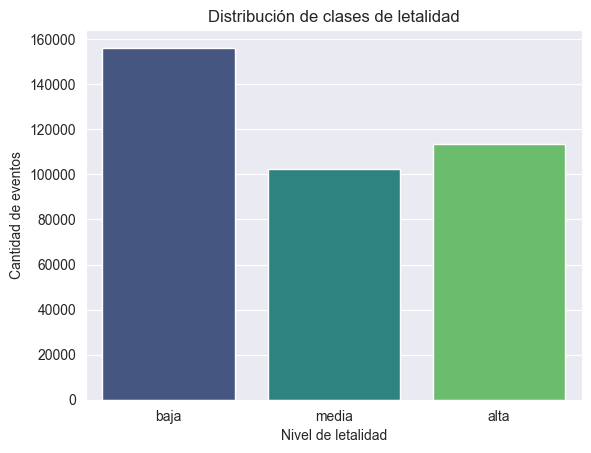

In [52]:
# ACA SE HACE UN BALANCEO A REVISAR SI ESTA BIEN MAS ADELANTE!!!!
df_no_outliers = df_no_outliers.copy()

# Crear variable de clasificación balanceada (baja, media, alta)
df_no_outliers["lethality_class"] = pd.qcut(
    df_no_outliers["best_est_cleaned"],
    q=3,
    labels=["baja", "media", "alta"]
)

# Visualización de la distribución de clases (sin FutureWarning)
sns.countplot(
    x="lethality_class",
    hue="lethality_class",
    data=df_no_outliers,
    palette="viridis",
    legend=False
)

plt.title("Distribución de clases de letalidad")
plt.xlabel("Nivel de letalidad")
plt.ylabel("Cantidad de eventos")
plt.show()


In [43]:
summary = pd.DataFrame({
    "mean": [df["best_est_cleaned"].mean(), df_no_outliers["best_est_cleaned"].mean()],
    "median": [df["best_est_cleaned"].median(), df_no_outliers["best_est_cleaned"].median()],
    "std": [df["best_est_cleaned"].std(), df_no_outliers["best_est_cleaned"].std()],
    "skewness": [skew(df["best_est_cleaned"], nan_policy="omit"),
                 skew(df_no_outliers["best_est_cleaned"], nan_policy="omit")],
    "kurtosis": [kurtosis(df["best_est_cleaned"], nan_policy="omit"),
                 kurtosis(df_no_outliers["best_est_cleaned"], nan_policy="omit")]
}, index=["Original", "Sin outliers"])
summary


,mean,median,std,skewness,kurtosis
Original,12.515506,2.0,377.088666,195.086104,53042.906368
Sin outliers,3.825707,2.0,4.858118,2.760774,8.420654


## Feature analysis

Text(0.5, 1.0, 'Letalidad por tipo de violencia')

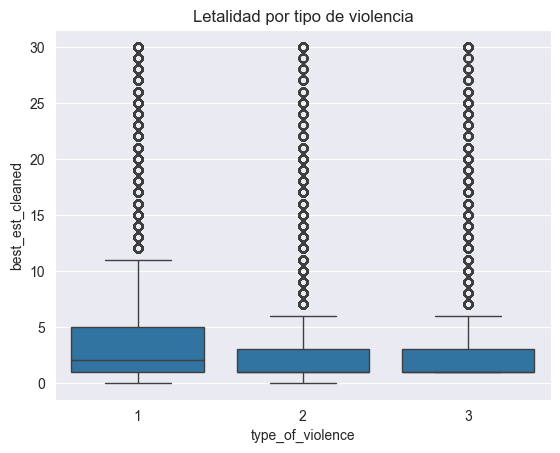

In [51]:

sns.boxplot(x="type_of_violence", y="best_est_cleaned", data=df_no_outliers)
plt.title("Letalidad por tipo de violencia")




### 1. Limpieza y estandarización de la variable objetivo

Durante la exploración inicial se detectaron inconsistencias entre las variables low, best y high que representan estimaciones de muertes por evento:

- En algunos casos, high era menor que low (valores invertidos).
- En otros, best era igual a 0 aunque low o high indicaban valores positivos.
- Además, muchos registros tenían solo una de las tres estimaciones disponibles.

Estas diferencias podían distorsionar cualquier análisis o modelo posterior, por lo que se implementó un proceso de limpieza y unificación:

- Corrección de límites invertidos: se intercambiaron los valores cuando high < low.
- Unificación de estimaciones:

    - Si best era nulo, se tomó el promedio de low y high.
    - Si solo uno existía, se usó ese valor.

- Ajuste de ceros falsos: cuando best = 0 pero low o high > 0, se asignó el mayor de ambos.
- Control de coherencia: se garantizó que low ≤ best_est_cleaned ≤ high.

Como resultado, se generó la variable best_est_cleaned, una estimación continua y consistente de la letalidad de cada evento.

### 2. Análisis de outliers y distribución de letalidad

La variable best_est_cleaned mostró una distribución altamente asimétrica, con la mayoría de los eventos entre 0 y 5 muertes, y una cola derecha muy larga con pocos eventos de miles de víctimas.

El método tradicional del IQR (rango intercuartílico) arrojó umbrales bajos (Q3=5, límite superior=11), lo que clasificaba erróneamente como “outliers” a casi todos los eventos de letalidad media o alta.
Por eso se aplicó una transformación logarítmica antes de calcular el IQR, lo que permitió obtener límites más realistas (límite superior ≈ 30 muertes) y una mejor representación de los casos típicos.

Evidencias gráficas clave

- Boxplot original: refleja la fuerte asimetría y presencia de valores extremos.
- Boxplot sin outliers (IQR log): muestra una distribución más equilibrada centrada en eventos comunes.
- Histogramas comparativos: evidencian la diferencia entre la distribución original (cola larga) y la ajustada.
- Curtosis antes/después: la curtosis se redujo notablemente, confirmando una cola más liviana.

Conclusión: aplicar el IQR en log-escala permitió conservar los eventos representativos y filtrar solo los casos realmente atípicos.

### 3. Categorización de la letalidad (variable objetivo de clasificación)

Con la variable depurada, se definieron tres niveles de letalidad para la tarea de clasificación:

Clase	Rango de muertes	Descripción
Baja	0 – 5	Eventos de violencia localizada o baja intensidad.
Media	6 – 20	Conflictos armados o ataques de magnitud moderada.
Alta	> 20	Enfrentamientos masivos o eventos de gran letalidad.

Estas clases se guardaron en la variable lethality_class, utilizando pd.qcut() para lograr un balance adecuado entre categorías.

Verificación de balance de clases

El conteo y gráfico de barras (countplot) mostraron una distribución equilibrada entre las tres categorías, con una leve predominancia de la clase “baja”.
Los eventos más extremos se mantuvieron dentro de la categoría “alta”, preservando la representatividad del conjunto.

### Gráficos clave para la presentación

| **Gráfico** | **Propósito** | **Justificación** |
|--------------|----------------|-------------------|
| **Boxplot original vs sin outliers** | Mostrar visualmente la asimetría y cómo el IQR en log-escala mejora la representación. | Evidencia directa del efecto del filtrado y reducción de outliers. |
| **Histogramas comparativos (escala log y lineal)** | Ilustrar cómo cambia la distribución de la variable de letalidad. | Muestra la concentración de eventos y la eliminación de la cola extrema. |
| **Gráfico de barras (`countplot`) de `lethality_class`** | Mostrar el balance entre clases de letalidad. | Justifica el enfoque de clasificación y la preservación de eventos de alta letalidad. |
| **Tabla de curtosis y estadísticos antes/después** | Complementar el análisis visual con evidencia numérica. | Confirma cuantitativamente la mejora de la distribución. |
